In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sys.path.append('/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code')
import nibabel as nib
from dn_utils.behavioral_models import load_behavioral_data                          
from bids import BIDSLayout
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
from nistats.first_level_model import FirstLevelModel
from nistats.reporting import plot_design_matrix
from nistats.thresholding import map_threshold
from nistats.design_matrix import make_first_level_design_matrix

/home/kmb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [77]:
class Regressor():
    '''Implements representation of the single GLM regressor.
    
    Allows for conversion of regressor described as number of onsets and 
    optionally magnitude modulations into estimated BOLD timecourse through 
    make_first_level_design_matrix function from Nistats. Useful in situations
    where there are mutliple parametrically modulated regressors. Automatically
    handled both cases of unmodulated and modulated regressors.
    '''    

    def __init__(self, name, frame_times, onset, 
                 duration=None, modulation=False):
        '''
        Args:
            name (str): Name of the regressor.
            frame_times (array of shape (n_frames,)):
                The timing of acquisition of the scans in seconds.
            onset (np.array): 
                Specifies the start time of each event in seconds.
            duration (np.array, optional): 
                Duration of each event in seconds. Defaults duration is set to 
                0 (impulse function).
            modulation (np.array, optional): 
                Parametric modulation of event amplitude. Before convolution 
                regressor is demeaned. 
        '''
        self._name = name
        self._onset = onset
        self._frame_times = frame_times
        self._n_events = len(onset)
        
        if modulation is not False:
            if modulation.shape != onset.shape:
                raise ValueError(
                    'onset and modulation have to be the same shape, but '\
                    '{} and {} were passed'.format(modulation.shape, onset.shape)
                )
        else:
            self._modulation = False
        self._modulation = modulation
        
        if duration is None:
            self._duration = np.zeros(onset.shape)
        else:
            if duration.shape != onset.shape:
                raise ValueError(
                    'onset and duration have to be the same shape, but '\
                    '{} and {} were passed'.format(duration.shape, onset.shape)
                )
            self._duration = duration
            
        self._dm_column = self._create_dm_column()
            
    @property
    def name(self):
        return self._name
                
    @property
    def dm_column(self):
        return self._dm_column
    
    def _create_dm_column(self) -> pd.DataFrame:
        '''Create column of design matrix corresponding to regressor modulation.
        
        Args:

                
        Returns:
            Regressor time-course convolved with HRF.        
        '''
        
        events_dict = {
            'onset': self._onset,
            'duration': self._duration,
            'trial_type': np.ones(self._n_events)
        } 

        if self._modulation is not False:
            events_dict['modulation'] = self._modulation

        events = pd.DataFrame(events_dict        )
        events.loc[:, "trial_type"] = self.name
        
        if self._modulation is not False:
            events['modulation'] -= events['modulation'].mean()
        
        dm = make_first_level_design_matrix(self._frame_times, events, drift_model=None)
        dm = dm.drop('constant', axis=1)

        return dm
    
    def plot_regressor(self, color='r') -> None:
        '''Plots BOLD timecourse for regressors:
        
        Args:
            color: Plot line color.
        '''
        fig, ax = plt.subplots(facecolor='w', figsize=(25, 3))

        ax.plot(self._dm_column, color)
        ax.set_xlim(0, np.max(frame_times))
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('est. BOLD')
        ax.grid()
        
    @classmethod
    def corrcoef(cls, reg1, reg2):
        '''Return correlation between two regressors'''
        
        rval = np.corrcoef(
            reg1.dm_column.values.T, 
            reg2.dm_column.values.T
        )
        
        return rval[0,1]

### Load task onsets

Load behavioral data containg relevant task onsets. 

In [2]:
beh_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
          "data/main_fmri_study/sourcedata/behavioral"
beh, meta = load_behavioral_data(root=beh_dir)
n_subjects, n_conditions, n_trials, _ = beh.shape

Shape of beh array: (32, 2, 110, 21)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'rwd'), (2, 'magn_left'), (3, 'magn_right'), (4, 'response'), (5, 'rt'), (6, 'won_bool'), (7, 'won_magn'), (8, 'acc_after_trial'), (9, 'onset_iti'), (10, 'onset_iti_plan'), (11, 'onset_iti_glob'), (12, 'onset_dec'), (13, 'onset_dec_plan'), (14, 'onset_dec_glob'), (15, 'onset_isi'), (16, 'onset_isi_plan'), (17, 'onset_isi_glob'), (18, 'onset_out'), (19, 'onset_out_plan'), (20, 'onset_out_glob')]


### Query neuroimaging dataset (path extraction)

Using BIDSLayout object query BIDS dataset to pull out necessary files.
- `anat_files`: sorted list of preprocessed T1w images
- `fmri_files`: list of two lists containing sorted (by subject number) paths to imaging files, first list corresponds to reward condition of PRL task and second list corresponds to punishment condition of PRL task
- `conf_files`: list of two lists containing sorted (by subject number) paths to confound files
- `mask_files`: brain mask files for fmri sequencnes

In [3]:
bids_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/main_fmri_study"

layout = BIDSLayout(
    root=bids_dir,
    derivatives=True,
    validate=True,
    index_metadata=False
)

anat_filter = {
    "extension": [".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "suffix": "T1w",
    "desc": "preproc",
    "return_type": "filename"
}

fmri_filter = {
    "extension": [".nii", ".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "suffix": "bold",
    "desc": "preproc",
    "return_type": "filename"
}

conf_filter = {
    "extension": "tsv",
    "desc": "confounds",
    "return_type": "filename"
}

mask_filter = {
    "extension": [".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "desc": "brain",
    "suffix": "mask",
    "return_type": "filename"
}

anat_files = layout.get(**anat_filter)

fmri_files, conf_files, mask_files = [], [], []

for task_dict in [{"task": "prlrew"}, {"task": "prlpun"}]:
    fmri_filter.update(task_dict)
    conf_filter.update(task_dict)
    mask_filter.update(task_dict)
    fmri_files.append(layout.get(**fmri_filter))
    conf_files.append(layout.get(**conf_filter))
    mask_files.append(layout.get(**mask_filter))

In [4]:
# Load model-based regresssor(s)
pe_regressors_path = 'data/pe_regressors.npy'
pe_regressors = np.load(pe_regressors_path)

### Single subject analysis

Here, first level GLM analysis is performed for each subject. For each imaging sequence following steps are applied:
1. relevant files are loaded: anatomical, functional, brain mask for functional file
2. `confounds` dataframe is loaded and filtered. Included confounds are: six motion parameters and first five a_comp_cor regressors
4. glm model is evaluated (beta estimates for all regressors)
5. ...

Regressors of interest:
- parametrically modulated PE regressor

In [79]:
out_dir = '/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/'\
          'main_fmri_study/derivatives/nistats/pefull'

# Specify GLM
fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model='ar1',
    drift_model='cosine',
    period_cut=128,
    standardize=False,
    hrf_model='spm',
    smoothing_fwhm=6)

In [81]:
# Single modulated PE regressor
for sub_idx in range(n_subjects):

    print(f"Analyzing sub-{meta['dim1'][sub_idx]}...")
    
    for con_idx in range(n_conditions):
        
        # Load imaging data
        anat_img = nib.load(anat_files[sub_idx])
        fmri_img = nib.load(fmri_files[con_idx][sub_idx])
        fmri_glm.mask = nib.load(mask_files[con_idx][sub_idx])

        # Calculate times of image acquisition in seconds
        n_scans, t_r = 730, 2
        frame_times = np.arange(n_scans) * t_r

        # Get subject data
        resp_type = beh[sub_idx, con_idx, :, meta['dim4'].index('response')]
        out_onset = beh[sub_idx, con_idx, :, meta['dim4'].index('onset_out')]
        pe_regressor = pe_regressors[sub_idx, con_idx, resp_type != 0]

        # Construct regressors of interest
        r1 = Regressor(
            'pe', 
            frame_times=frame_times,
            onset=out_onset[resp_type != 0], 
            modulation=pe_regressor
        )
        r2 = Regressor(
            'pe_miss',
            frame_times=frame_times,
            onset=out_onset[resp_type == 0]
        )

        # Grab and filter confounds
        confounds_relevant = ['a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 
                              'a_comp_cor_03', 'a_comp_cor_04', 'trans_x', 'trans_y', 
                              'trans_z', 'rot_x', 'rot_y', 'rot_z']
        confounds = pd.read_csv(conf_files[con_idx][sub_idx], sep='\t')
        confounds = confounds[confounds_relevant]
        confounds.index = frame_times # change to standard time representation (in seconds)

        dm_glm = make_first_level_design_matrix(
            frame_times=frame_times,
            add_regs = pd.concat([r1.dm_column, r2.dm_column, confounds], axis=1, sort=False),
            add_reg_names = [r1.name, r2.name] + list(confounds.columns)
        )

        # Fit GLM
        fmri_glm = fmri_glm.fit(fmri_img, design_matrices=dm_glm)

        # Define contrast
        design_matrix = fmri_glm.design_matrices_[0]
        conditions = {'pe': np.zeros(design_matrix.shape[1])}
        conditions['pe'][list(design_matrix.columns).index('pe')] = 1

        # Compute statistical map and save it
        z_map = fmri_glm.compute_contrast(conditions['pe'], stat_type='t')
        z_map_fname = f"sub-{meta['dim1'][sub_idx]}_task-prl{meta['dim2'][con_idx]}_desc-pefull_tmap"

        nib.save(z_map, os.path.join(out_dir, z_map_fname))

/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


### Show example statistical map

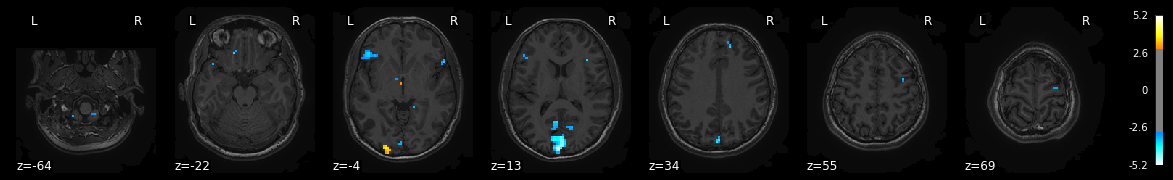

In [84]:
# (optional) Display first-level results in the brain space
_, threshold = map_threshold(
    z_map, 
    level=.1, 
    height_control='fdr')

plot_stat_map(
    z_map, 
    bg_img=anat_img,
    threshold=3,
    display_mode='z')